<h1>An Intuitive Explanation of Policy Gradient - Part 1: REINFORCE<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Utility-code" data-toc-modified-id="Utility-code-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Utility code</a></span></li></ul></li></ul></li><li><span><a href="#Resources-and-Context" data-toc-modified-id="Resources-and-Context-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Resources and Context</a></span><ul class="toc-item"><li><span><a href="#The-Problem-with-Policy-Gradient" data-toc-modified-id="The-Problem-with-Policy-Gradient-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The Problem with Policy Gradient</a></span></li><li><span><a href="#Motivating-Policy-Gradient" data-toc-modified-id="Motivating-Policy-Gradient-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Motivating Policy Gradient</a></span></li></ul></li><li><span><a href="#Explaining-Policy-Gradient" data-toc-modified-id="Explaining-Policy-Gradient-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explaining Policy Gradient</a></span><ul class="toc-item"><li><span><a href="#Simple-Policy-Gradient-Ascent" data-toc-modified-id="Simple-Policy-Gradient-Ascent-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Simple Policy Gradient Ascent</a></span></li><li><span><a href="#Weighing-the-Gradients" data-toc-modified-id="Weighing-the-Gradients-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Weighing the Gradients</a></span></li><li><span><a href="#On-Policy-Correction" data-toc-modified-id="On-Policy-Correction-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>On-Policy Correction</a></span></li><li><span><a href="#Basic-REINFORCE" data-toc-modified-id="Basic-REINFORCE-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Basic REINFORCE</a></span></li><li><span><a href="#The-Advantage-Function-and-Baselines" data-toc-modified-id="The-Advantage-Function-and-Baselines-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>The Advantage Function and Baselines</a></span></li></ul></li></ul></div>

## Introduction

#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable as V

import gym
import gym.spaces
import random
gym.logger.set_level(gym.logger.ERROR)
import numpy as np
from collections import namedtuple
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from builtins import super
from IPython.display import display, Image

#### Utility code

In [2]:
def simulate_policy_gradient(update_fn, filename, init=[0.0]*3):
    a = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.010)
    b = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.005)
    c = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.0025)
    sliders = [a, b, c]
    for i, s in zip(init, sliders):
        s.logit = i
        s.q_val = s.step * 1000
    
    def update_values():
        exps = [np.exp(e.logit) for e in sliders]
        for ex, slid in zip(exps, sliders):
            slid.value = ex / np.sum(exps)
            slid.grad = slid.value * (1-slid.value)
            
    update_values()
    
    def f(a_val10, b_val8, c_val7):
        pass
    
    np.random.seed(1)
    it = 0
    animation_data = []
    while all([v.value < 0.95 for v in [a, b, c]]):
        incr_idx, incr_size = update_fn(sliders)
        update_values()
        it += 1
        animation_data.append((incr_idx, incr_size, [v.value for v in sliders]))
        
    if filename is not None:
        fig, ax = plt.subplots()

        def plot_animation(i):
            plt.clf()
            incr_idx, incr_size, values = animation_data[i]
            plt.bar(['Val = %s' % (v.step * 1000) for v in sliders], values, width=0.5)
            plt.ylim(0, 1.19)
            if incr_size > 0:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx] + incr_size + 0.05), xycoords='data',
                    xytext=(incr_idx, values[incr_idx]), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='green'),
                )
            else:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx]), xycoords='data',
                    xytext=(incr_idx, values[incr_idx] - incr_size + 0.05), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='red'),
                )
            return fig,

        ani = animation.FuncAnimation(fig, plot_animation, frames=list(range(0, len(animation_data))), blit=False)
        ani.save(filename, writer='imagemagick', fps=10)
        plt.close()
        display(Image(filename))    
    
    print('Done in %s iterations' % it)


## Resources and Context

This is part 1 of a series of tutorials which I expect to have 2 or 3 parts. The next part will be on A2C and, time providing, I hope to complete a part on various forms of off-policy policy gradients.

Some valuable resources

# TODO

### The Problem with Policy Gradient

Some of today's most successful reinforcement learning algorithms, from A3C to TRPO to PPO belong to the **policy gradient** family of algorithm, and often more specifically to the **actor-critic** family. Clearly as an RL enthusiast, you owe it to yourself to have a good understanding of the policy gradient method, which is why so many tutorials out there attempt to describe them.

Yet, if you've ever tried to follow one of these tutorials, you were proably faced with an equation along the following lines:
$$\nabla_\theta J(\theta) = \hat{A}(s, a) \nabla_\theta \log \pi_\theta(s | a)$$

or perhaps the related update rule:

$$\theta_{t+1} = \theta_t + \alpha \hat{A}(s, a) \nabla_\theta \log \pi_\theta(s | a)$$

or perhaps even the loss function:

$$\mathcal{L} = -\hat{A}(s, a) \log \pi(s | a)$$

Most likely this was accompanied by a very handwavy explanation, a ton of complicated math, or no explanation at all.

Indeed, some of my favorite tutorials on Reinforcement Learning are guilty of this. Jaromiru's [Let's make an A3C](jaromiru.com/2017/02/16/lets-make-an-a3c-theory) states:
> The second term inside the expectation, $\nabla_\theta \log \pi(a|s)$, tells us a direction in which logged probability of taking action a in state s rises. Simply said, how to make this action in this context more probable.

While Arthur Juliani states in [Simple Reinforcement Learning with Tensorflow](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149):
> Intuitively, this loss function allows us to increase the weight for actions that yielded a positive reward, and decrease them for actions that yielded a negative reward.

Both of these explanations are highly unsatisfactory. Specifically, they completely fail to explain the presence of the mysterious $\log$ function in these formulas. <!--- Improve starting here: --> If you only remembered their intuitive explanations, you would not be able to write down the loss function yourself. This is not OK.

Amazingly, there actually **is** a perfectly intuitive explanation of this formula! However, as far as I know the only clear statement of this intuition is hidden in Chapter 13, section 3 of Sutton & Barto's [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).

Once I describe it to you in painstaking details, you will be able to account for the presence of the $\log$ function and you should be able to write down the formula from first principles. Indeed, you will also be able to come up with your own variants policy gradient!

In this post, I will assume that you already have some basic notions of Reinforcement Learning, and in particular that you are familiar with Q-Learning and, ideally, DQNs.

If you aren't yet familiar with Q-Learning, I suggest you read at least the introduction of one of the many great DQN tutorials out there. Some suggestions:
- [Beat Atari with Deep Reinforcement Learning](https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec) by yours truly
- [Let's Make a DQN](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/) by Jaromiru
- [Simple Reinforcement Learning with Tensorflow](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0) by Arthur Juliani

### Motivating Policy Gradient

<!---
In this section, we try to develop the intuition on REINFORCE given in Sutton & Barto, section 13.3:

> The update increases the parameter vector in this direction proportional to the return, and inversely proportional to the action probability. The former makes sense because it causes the parameter to move most in the directions that favor actions that yield the highest return. The latter makes sense because otherwise actions that are selected frequently are at an advantage (the updates will be more often in their direction) and might win out even if they do not yield the highest return.
-->

Before going any further, let's learn about some of the advantages of policy gradient methods over Q-Learning, as extra motivation to try to genuinely understand policy gradient:
- The policy implied by Q-Learning is deterministic. This means that Q-Learning can't learn stochastic policies, which can be useful in some environments. It also means that we need to create our own exploration strategy since following the policy will not perform any exploration. We usually do this with $\epsilon$-greedy exploration, which can be quite inefficient.
- There is no straightforward way to handle continuous actions in Q-Learning. In policy gradient, handling continous actions is relatively easy.
- As its name implies, in policy gradient we are following gradients with respect to the policy itself, which means we are constantly improving the policy. By contrast, in Q-Learning we are improving our estimates of the values of different actions, which only implicitely improves the policy. You would think that improving the policy directly would be more efficient, and indeed it very often is.

In general, policy gradient methods have very often beaten value-based methods such as DQNs on modern tasks such as playing Atari games.

## Explaining Policy Gradient

### Simple Policy Gradient Ascent

Although this article aims to provide intuition on policy gradients and thus aims to not be too mathematical, our goal is still to explain an equation, and so we need to use some mathematical notation, which I will introduce  as needed throughout the article. Let's start with our first fundamental pieces of notation:

The letter $\pi$ will symbolize a policy. Let's call $\pi_\theta(a|s)$ the probability of taking action $a$ in state $s$. $\theta$ represents the parameters of our policy (the weights of our neural network).

Our goal is to update $\theta$ to values that make $\pi_\theta$ the optimal policy. Because $\theta$ will change, we will use the notation $\theta_t$ to denote $\theta$ at iteration $t$. We want to find out the update rule that takes use from $\theta_t$ to $\theta_{t+1}$ in a way that we eventually reach the optimal policy using policy gradient.

Typically, for a discrete action space, $\pi_\theta$ would be a neural network with a **softmax** output unit, so that the output can be thought of as the probability of taking each action.

Clearly, if action $a^*$ is the optimal action, we want $\pi_\theta(a^*|s)$ to be as close to 1 as possible.

For this we can simply perform gradient *ascent* on $\pi_\theta(a^*|s)$, so at each iteration we update $\theta$ in the following way:
$$\theta_{t+1} = \theta_t + \alpha \nabla \pi_{\theta_t}(a^*|s)$$

We can view the gradient $\nabla \pi_{\theta_t}(a^*|s)$ as being "the direction in which to move $\theta_t$ so as to *increase* the value of $\pi_{\theta_t}(a^*|s)$ the fastest". Note that we are indeed using gradient *ascent* since we want to *increase* a value, not *decrease* it as is usual in deep learning.

Thus one way to view this update is that we keep "pushing" towards more of action $a^*$ in our policy, which is indeed what we want.

In the example below, we know that the first action is the best action, so we run gradient ascent on it. For this running example we will assume a single state s so that the evolution of the policy is easier to plot. We will generalize to multiple states later in this post when we introduce A2C.

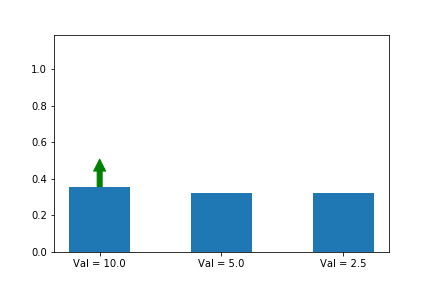

Done in 55 iterations


In [6]:
lr = 0.5

def update_known_optimal(actions):
    # Each action has a .logit attribute that we must update. It also has a .grad attribute
    # that gives the gradient of the that action.
    actions[0].logit += lr * actions[0].grad
    # We return the index of the action we updated and the size of the arrow to draw
    # (which should be the size of our update, divided by a scaling factor to make the 
    # visual more pleasant)
    return 0, lr / 5
    
simulate_policy_gradient(update_known_optimal, 'known_optimal.gif')

### Weighing the Gradients

Of course, in practice, we won't know which action is best... After all that's what we're trying to figure out in the first place!

To get back to the metaphor of "pushing", if we don't know which action is optimal, we might "push" on suboptimal actions and our policy will never converge.

One solution would be to "push" on actions in a way that is *proportional to our guess of the value* of these actions. These guesses can be highly approximate, but as long as they are somewhat grounded in reality, more overall pushing will happen on the optimal action $a^*$. This way it is guaranteed that eventually our policy will converge to $a^* = 1$!

We will call our guess of the value of action a in state s $\hat{Q}(s, a)$. Indeed, this is very similar to the Q function that we know from Q-Learning, though there is a subtle and important difference that will make it easier to learn and that we will learn about later. For now, let's just assume that this Q function is a given.

We get the following gradient ascent update, that we can now apply to each action in turn instead of just to the optimal action:
$$\theta_{t+1} = \theta_t + \alpha \hat{Q}(s, a) \nabla \pi_{\theta_t}(a|s)$$

Let's weigh our updates to the simulated policy gradient using a noisy version of the Q values of the different actions (10 for action a, 5 for action b, 2.5 for action c), and this time, we will randomly update each of the different possible actions, since we assume that we don't know which one is best. As we see, the first action does still end up winning, even though our estimates of the values (as shown by the lengths of the arrows) varies significantly across iterations.

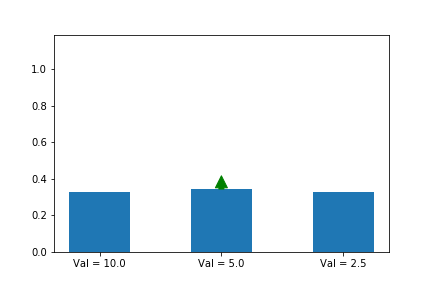

Done in 58 iterations


In [30]:
lr = 0.1

def update_q_value(actions):
    i = np.random.choice(list(range(len(actions))))
    # We add a significant amount of normally distributed noise to the action value,
    # which is given to us in the q_val attribute.
    value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * value_est * actions[i].grad
    return i, lr * value_est / 10
    
simulate_policy_gradient(update_q_value, 'random_action.gif')

### On-Policy Correction

Of course, in practice, our agent is not going to choose actions uniformly at random, which is what we implicitly assumed so far. Rather, we are going to follow the very policy $\pi_\theta$ that we are trying to train! This is called training **on-policy**. There are two reasons why we might want to train on-policy:
- We accumulate more rewards even as we train, which is something we might value in some contexts.
- It allows us to explore more promising areas of the state space by not exploring purely randomly but rather closer to our current guess of the optimal actions.

This creates a problem with our current training algorithm, however: although we are going to "push" stronger on the actions that have a better value, we are also going to "push" *more often* on whichever actions happen to have higher values of $\pi_\theta$ to begin with (which could happen due to chance or bad initialization)! These actions might end up winning the race to the top in spite of being bad.

Let's illustrate this phenomenon by using the same update rule but sampling actions according to their probability instead of uniformly:

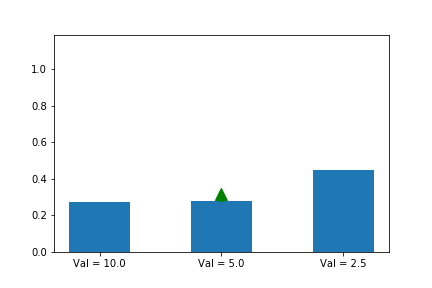

Done in 47 iterations


In [31]:
# Note: because using the advantage function partly compensates for this effect,
# we use the Q function here to make the effect more obvious.

lr = 0.1

def update_q_value_bad(actions):
    i = np.random.choice(list(range(len(actions))), p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * q_value_est * actions[i].grad
    return i, lr * q_value_est / 5
    
simulate_policy_gradient(update_q_value_bad, 'bad.gif', init=[0., 0., 0.5])

Here we can see that the third action, in spice of having a lower value than the other two, ends up winning because it starts out initialized much higher.

This means that we need to compensate for the fact that more probable actions are going to be taken more often. How do we do this? Simple: we *divide* our update by the probability of the action. This way, if an action is 4x more likely to be taken than another, we will have 4x more gradient updates to it but each will be 4x smaller.

This gives us the following update rule:
$$\theta_{t+1} = \theta_t + \alpha \frac{\hat{Q}(s, a) \nabla \pi_{\theta_t}(a|s)}{\pi_{\theta}(a|s)}$$

Let's try it:

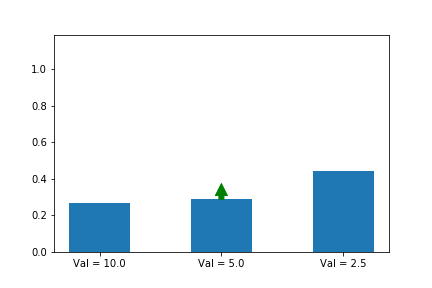

Done in 30 iterations


In [32]:
lr = 0.1

def update_q_value_fixed(actions):
    i = np.random.choice(list(range(len(actions))), p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * q_value_est * actions[i].grad / actions[i].value
    return i, lr * q_value_est / actions[i].value / 10
    
simulate_policy_gradient(update_q_value_fixed, 'final_policy_grad.gif', init=[0., 0.0, 0.5])

We now see that even though action 3 starts out with a significant advantage, action 1 eventually wins out because its updates are much larger when its probability is small. Exactly the behavior that we wanted!

### Basic REINFORCE

And we are now done explaining the intuition behind policy gradient! All the rest of this post is simply filling out some details. This is a significant accomplishment and you should feel proud of yourself for understanding this far!

"But, wait a minute", you say, "I thought you would tell us how to understand the mysterious update rule $\theta_{t+1} = \theta_t + \alpha \hat{A}(s, a) \nabla_\theta \log \pi_\theta(s | a)$, but our update rule looks completely different!"

Ah yes, indeed our update rule looks different, but it is in fact essentially the same! As a reminder, the key point in our rule is
$$\frac{\hat{Q}(s, a) \nabla \pi_{\theta_t}(a|s)}{\pi_{\theta}(a|s)}$$
while the original rule contains 
$$\hat{A}(s, a) \nabla_\theta \log \pi_\theta(s | a)$$

The next section will explain the difference between $\hat{A}$ and $\hat{Q}$, but suffice it to say for now that both work perfectly fine, but that using $\hat{A}$ is an optimization. 

The only difference remaining is thus between
$$\nabla_\theta \log \pi_\theta(s | a)$$
and
$$\frac{\nabla \pi_{\theta_t}(a|s)}{\pi_{\theta}(a|s)}$$

In fact, these two expressions are equivalent! This is due to the chain rule and the fact that the derivative of $\log x$ is $\frac{1}{x}$, as you might know from calculus. So we have in general:
$$\nabla \ln f(x) = \frac{\nabla f(x)}{f(x)}$$

So now you know the origin of the mysterious log function in the policy gradient update! So why do people use the form using the log function instead of the more intuitive one which divides by $\pi(s|a)$? I can see two reasons for this:
1. It obfuscates the intuition behind policy gradient, thus making you seem more impressive for understanding it.
1. It makes it possible to express the update as a loss function when doing gradient descent, as in the equation $\mathcal{L} = -\hat{A}(s, a) \log \pi_\theta(s | a)$ we saw at the beginning (bringing $\hat{A}(s, a)$ inside the loss function is fine since it is a constant with respect to $\theta$). This way you can use your favorite deep learning library to train your policy (which we will see how to do soon!).

At this point you now understand the basic form of the REINFORCE algorithm, which, as I am sure you expect, stands for "REward Increment = Nonnegative Factor $\times$ Offset Reinforcement $\times$ Characteristic Eligibility"... (yes I am serious, see [the original paper](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)). REINFORCE is the fundamental policy gradient algorithm on which nearly all the advanced policy gradient algorithms you might have heard of are based.

### The Advantage Function and Baselines

Now the final thing left to explain, as promised, is the difference between $\hat{Q}$ and $\hat{A}$. You should already be familiar with Q from Q-Learning: $Q(s, a)$ is the value (cumulative discounted reward, to be exact) obtained by taking action a in state s, and then following our policy $\pi$ thereafter.

Note that it may be the case that following any action will give us a cumulative reward of, say, at least 100, but that some actions will be better than others, so that Q might be equal to, say, 101 for action a, 102 for action b and 100 for action c. As you can guess, this means that almost all of the weight of our update will tell us nothing about whether the current action is better, which is problematic.

You may also be familiar with the $V(s)$ function, which simply gives us the value of following the policy starting in state s and all the way after that. In the example above, V(s) will be larger than 100 since all the Q(s, a) are larger than 100.

By subtracting V(s) from Q(s, a), we get the *advantage function* A(s, a). This function tells us how much better or worse taking action a in state is is compared to acting according to the policy. In the example above, it will subtract the extra 100 from the Q values of all the action, providing more signal to noise ratio.

In this tutorial I always wrote $\hat{Q}$ or $\hat{A}$, with a "hat" on top of Q and A to emphasize that we are not using the "real" Q or A but rather an **estimate** of them. 

As it turns out, REINFORCE will still work perfectly fine if we subtract **any** function from $\hat{Q}(s, a)$ as long as that function does not depend on the action. This makes sense based on our previous intuition of course, since the only thing that matters is that we "push" *harder* on the actions that have a higher Q value, and subtracting any value that doesn't depend on the action will preserve the ranking of how hard we push on the various actions.

This means that using the $\hat{A}$ function instead of the $\hat{Q}$ function is perfectly allowable. In fact, it is widely recommended for the reasons described above and also because it is supposed to reduce the variance of the gradient updates. Note that $\hat{A}$ is not known for sure to be the best function to use instead of $\hat{Q}$, but in practice it generally works quite well.

Let's see what using $\hat{A}$ does in our simulation:

Running using A function


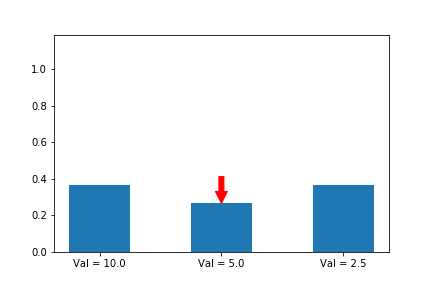

Done in 48 iterations
Variance of A gradients: 31.384320255389287
Running using Q function
Done in 30 iterations
Variance of Q gradients: 31.813126235495847


In [9]:
lr = 0.1

a_grad_muls = [[], [], []]
q_grad_muls = [[], [], []]

USE_A = True

def update_a_value(actions):
    i = np.random.choice(list(range(len(actions))), p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    v_value_est = np.sum([e.value * e.q_val for e in actions])
    a_value_est = q_value_est - v_value_est
    val_to_use = a_value_est if USE_A else q_value_est
    actions[i].logit += lr * val_to_use * actions[i].grad / actions[i].value
    a_grad_muls[i].append(a_value_est)
    q_grad_muls[i].append(q_value_est)
    return i, lr * val_to_use / actions[i].value / 15
    
print('Running using A function')
simulate_policy_gradient(update_a_value, 'advantage.gif')
print('Variance of A gradients:', np.mean([np.var(m) for m in a_grad_muls]))

print('Running using Q function')
USE_A = False
a_grad_muls = [[], [], []]
q_grad_muls = [[], [], []]
simulate_policy_gradient(update_a_value, None)
print('Variance of Q gradients:', np.mean([np.var(m) for m in q_grad_muls]))


Unfortunately, the impact is not dramatic here: the variance does end up slightly lower, but the time to converge is longer. That said, I am comparing the same learning rate between the two, and using the advantage function should let you use a higher learning rate without diverging. Further, this is a toy example and the benefits of using the advantage function has been widely attested in practice on larger problems. Sadly, this is the one instance in this tutorial in which you'll have to take my word for it that something works well.

You now have a full intuitive understanding of basic policy gradients. However, you might be wondering how to use these in practice: how do you represent a policy with a neural network? How do you get your $\hat{A}$ estimate in the first place? What other tricks are used in practice to make this work?

We will learn about all of this soon in part 2, which will explain the A2C algorithm.